# Atlas 14 Hyetograph Generation

This notebook demonstrates how to generate design storm hyetographs using NOAA Atlas 14 temporal distributions with the `Atlas14Storm` module.

## Purpose

Generate design storm hyetographs for HMS and RAS **without requiring HEC-HMS execution**, using the same Atlas 14 temporal distributions that HEC-HMS uses internally.

## What You Will Learn

1. Configure Atlas14Storm for a specific region and duration
2. Generate hyetographs with depth conservation verification
3. Work with DDF (Depth-Duration-Frequency) tables
4. Visualize and export hyetographs for downstream use

## Prerequisites

- Internet connection (for NOAA data download on first use)
- Understanding of design storm concepts (AEP, DDF tables)

## Related Notebooks

- **Notebook 11** (FrequencyStorm): Variable duration storms using TP-40 patterns
- **Notebook 13** (Validation): Multi-duration validation with detailed equivalence proofs

In [1]:
# pip install hms-commander

**For Development**: If working on hms-commander source code, use the `hmscmdr_local` conda environment (editable install) instead of pip install.

In [2]:
from dataclasses import dataclass
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from hms_commander import Atlas14Storm

print("Atlas14Storm module loaded")
print(f"Supported durations: {Atlas14Storm.SUPPORTED_DURATIONS} hours")

Atlas14Storm module loaded
Supported durations: [6, 12, 24, 96] hours


## 1. Atlas 14 Configuration

Atlas 14 data is organized by state, region, and duration. This example uses Houston, TX (Region 3).

In [3]:
# Houston, TX - Atlas 14 Volume 11, Region 3
STATE = "tx"
REGION = 3
DURATION_HOURS = 24

print("Atlas 14 Configuration:")
print("=" * 50)
print(f"  Location: Houston, TX")
print(f"  State Code: {STATE}")
print(f"  Region: {REGION}")
print(f"  Duration: {DURATION_HOURS} hours")
print(f"\nData Source: NOAA Precipitation Frequency Data Server")
print(f"URL: https://hdsc.nws.noaa.gov/pub/hdsc/data/{STATE}/")

Atlas 14 Configuration:
  Location: Houston, TX
  State Code: tx
  Region: 3
  Duration: 24 hours

Data Source: NOAA Precipitation Frequency Data Server
URL: https://hdsc.nws.noaa.gov/pub/hdsc/data/tx/


## 2. DDF Table (Depth-Duration-Frequency)

A DDF table provides total precipitation depths for various return periods (AEP = Annual Exceedance Probability).

In [4]:
@dataclass
class DDFEntry:
    """Depth-Duration-Frequency table entry."""
    ari_years: int      # Average Recurrence Interval (years)
    aep_percent: float  # Annual Exceedance Probability (%)
    depth_inches: float # Total precipitation depth (inches)
    
    @property
    def ari_str(self) -> str:
        return f"{self.ari_years}-year"
    
    @property
    def aep_str(self) -> str:
        return f"{self.aep_percent}"

# Houston, TX - Atlas 14 24-hour DDF values
DDF_TABLE = [
    DDFEntry(ari_years=2, aep_percent=50.0, depth_inches=5.00),
    DDFEntry(ari_years=5, aep_percent=20.0, depth_inches=6.80),
    DDFEntry(ari_years=10, aep_percent=10.0, depth_inches=8.30),
    DDFEntry(ari_years=25, aep_percent=4.0, depth_inches=10.90),
    DDFEntry(ari_years=50, aep_percent=2.0, depth_inches=13.30),
    DDFEntry(ari_years=100, aep_percent=1.0, depth_inches=17.90),
    DDFEntry(ari_years=200, aep_percent=0.5, depth_inches=19.70),
    DDFEntry(ari_years=500, aep_percent=0.2, depth_inches=22.80),
]

print("Houston, TX - 24-Hour DDF Table (Atlas 14)")
print("=" * 55)
print(f"{'ARI':>10} {'AEP (%)':>10} {'Depth (in)':>12}")
print("-" * 55)
for entry in DDF_TABLE:
    print(f"{entry.ari_str:>10} {entry.aep_percent:>10.1f} {entry.depth_inches:>12.2f}")

Houston, TX - 24-Hour DDF Table (Atlas 14)
       ARI    AEP (%)   Depth (in)
-------------------------------------------------------
    2-year       50.0         5.00
    5-year       20.0         6.80
   10-year       10.0         8.30
   25-year        4.0        10.90
   50-year        2.0        13.30
  100-year        1.0        17.90
  200-year        0.5        19.70
  500-year        0.2        22.80


## 3. Generate Hyetographs

Generate hyetographs for all AEP events using `Atlas14Storm.generate_hyetograph()`.

The function returns a DataFrame with columns:
- `hour`: Time in hours from storm start
- `incremental_depth`: Precipitation depth in each interval (inches)
- `cumulative_depth`: Running total precipitation (inches)

In [5]:
print("Generating hyetographs for all DDF entries...")
print("=" * 70)

hyetographs = {}

for entry in DDF_TABLE:
    # Generate hyetograph
    hyeto = Atlas14Storm.generate_hyetograph(
        total_depth_inches=entry.depth_inches,
        state=STATE,
        region=REGION,
        duration_hours=DURATION_HOURS,
        aep_percent=entry.aep_percent,
        quartile="All Cases"  # Median temporal pattern
    )
    
    hyetographs[entry.ari_str] = hyeto
    
    # Statistics
    total = hyeto['cumulative_depth'].iloc[-1]
    peak = hyeto['incremental_depth'].max()
    peak_idx = hyeto['incremental_depth'].idxmax()
    peak_time = hyeto['hour'].iloc[peak_idx]
    
    # Verify total depth conservation
    diff = abs(total - entry.depth_inches)
    status = "PASS" if diff < 0.001 else "FAIL"
    
    print(f"{entry.ari_str:>10}: {len(hyeto)} intervals, "
          f"total={total:.3f} in, peak={peak:.3f} in @ {peak_time:.1f}h [{status}]")

print("\nAll hyetographs generated and verified.")

2026-01-08 13:29:43 - hms_commander.Atlas14Storm - INFO - Using cached temporal distribution: C:\Users\billk_clb\.hms-commander\atlas14\tx_3_24h_temporal.csv


2026-01-08 13:29:43 - hms_commander.Atlas14Storm - INFO - Parsed 5 quartile tables with 49 time steps each


2026-01-08 13:29:43 - hms_commander.Atlas14Storm - INFO - Generated hyetograph: 49 intervals, 5.000 inches total


2026-01-08 13:29:43 - hms_commander.Atlas14Storm - INFO - Using cached temporal distribution: tx_3_24h


2026-01-08 13:29:43 - hms_commander.Atlas14Storm - INFO - Generated hyetograph: 49 intervals, 6.800 inches total


2026-01-08 13:29:43 - hms_commander.Atlas14Storm - INFO - Using cached temporal distribution: tx_3_24h


2026-01-08 13:29:43 - hms_commander.Atlas14Storm - INFO - Generated hyetograph: 49 intervals, 8.300 inches total


2026-01-08 13:29:43 - hms_commander.Atlas14Storm - INFO - Using cached temporal distribution: tx_3_24h


2026-01-08 13:29:43 - hms_commander.Atlas14Storm - INFO - Generated hyetograph: 49 intervals, 10.900 inches total


2026-01-08 13:29:43 - hms_commander.Atlas14Storm - INFO - Using cached temporal distribution: tx_3_24h


2026-01-08 13:29:43 - hms_commander.Atlas14Storm - INFO - Generated hyetograph: 49 intervals, 13.300 inches total


2026-01-08 13:29:43 - hms_commander.Atlas14Storm - INFO - Using cached temporal distribution: tx_3_24h


2026-01-08 13:29:43 - hms_commander.Atlas14Storm - INFO - Generated hyetograph: 49 intervals, 17.900 inches total


2026-01-08 13:29:43 - hms_commander.Atlas14Storm - INFO - Using cached temporal distribution: tx_3_24h


2026-01-08 13:29:43 - hms_commander.Atlas14Storm - INFO - Generated hyetograph: 49 intervals, 19.700 inches total


2026-01-08 13:29:43 - hms_commander.Atlas14Storm - INFO - Using cached temporal distribution: tx_3_24h


2026-01-08 13:29:43 - hms_commander.Atlas14Storm - INFO - Generated hyetograph: 49 intervals, 22.800 inches total


Generating hyetographs for all DDF entries...
    2-year: 49 intervals, total=5.000 in, peak=0.143 in @ 4.0h [PASS]
    5-year: 49 intervals, total=6.800 in, peak=0.420 in @ 2.0h [PASS]
   10-year: 49 intervals, total=8.300 in, peak=0.759 in @ 2.0h [PASS]
   25-year: 49 intervals, total=10.900 in, peak=0.997 in @ 2.0h [PASS]
   50-year: 49 intervals, total=13.300 in, peak=1.217 in @ 2.0h [PASS]
  100-year: 49 intervals, total=17.900 in, peak=1.638 in @ 2.0h [PASS]
  200-year: 49 intervals, total=19.700 in, peak=1.803 in @ 2.0h [PASS]
  500-year: 49 intervals, total=22.800 in, peak=2.086 in @ 2.0h [PASS]

All hyetographs generated and verified.


## 4. Visualize Hyetographs

Compare hyetograph shapes across different return periods.

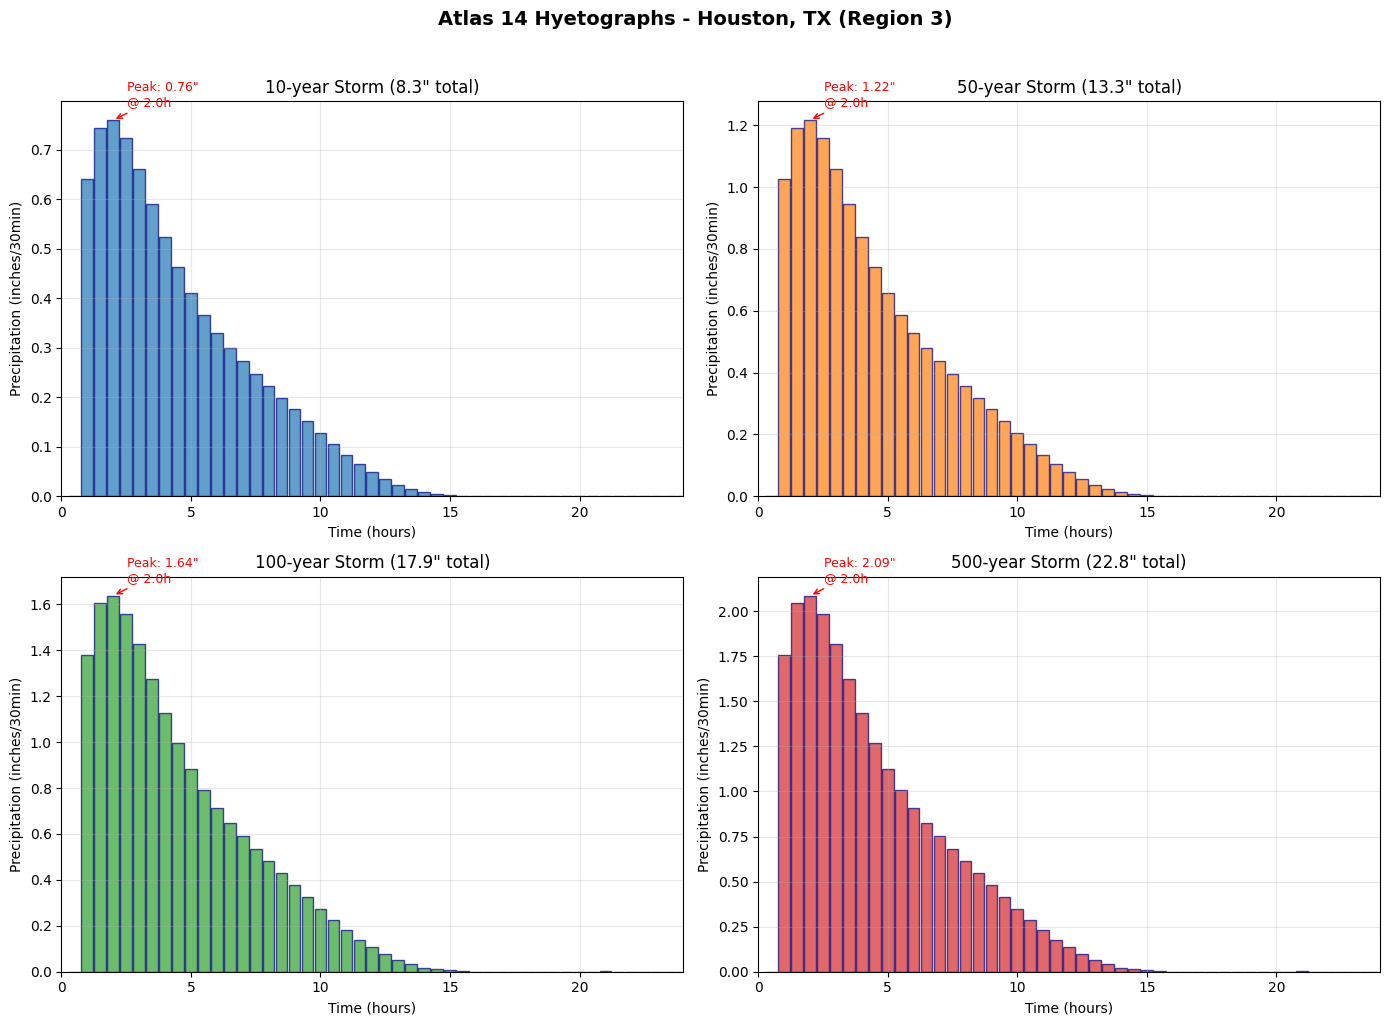

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Select 4 storms for visualization
storms_to_plot = ['10-year', '50-year', '100-year', '500-year']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for ax, storm_name, color in zip(axes.flat, storms_to_plot, colors):
    hyeto = hyetographs[storm_name]
    
    ax.bar(hyeto['hour'], hyeto['incremental_depth'], 
           width=0.45, color=color, alpha=0.7, edgecolor='navy')
    
    # Peak annotation
    peak_idx = hyeto['incremental_depth'].idxmax()
    peak_time = hyeto['hour'].iloc[peak_idx]
    peak_depth = hyeto['incremental_depth'].max()
    total = hyeto['cumulative_depth'].iloc[-1]
    
    ax.annotate(f'Peak: {peak_depth:.2f}"\n@ {peak_time:.1f}h',
                xy=(peak_time, peak_depth),
                xytext=(10, 10), textcoords='offset points',
                fontsize=9, color='red',
                arrowprops=dict(arrowstyle='->', color='red'))
    
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Precipitation (inches/30min)')
    ax.set_title(f'{storm_name} Storm ({total:.1f}" total)')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 24)

plt.suptitle('Atlas 14 Hyetographs - Houston, TX (Region 3)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 5. Cumulative Distribution Comparison

The temporal pattern is the same for all return periods - only the total depth changes.

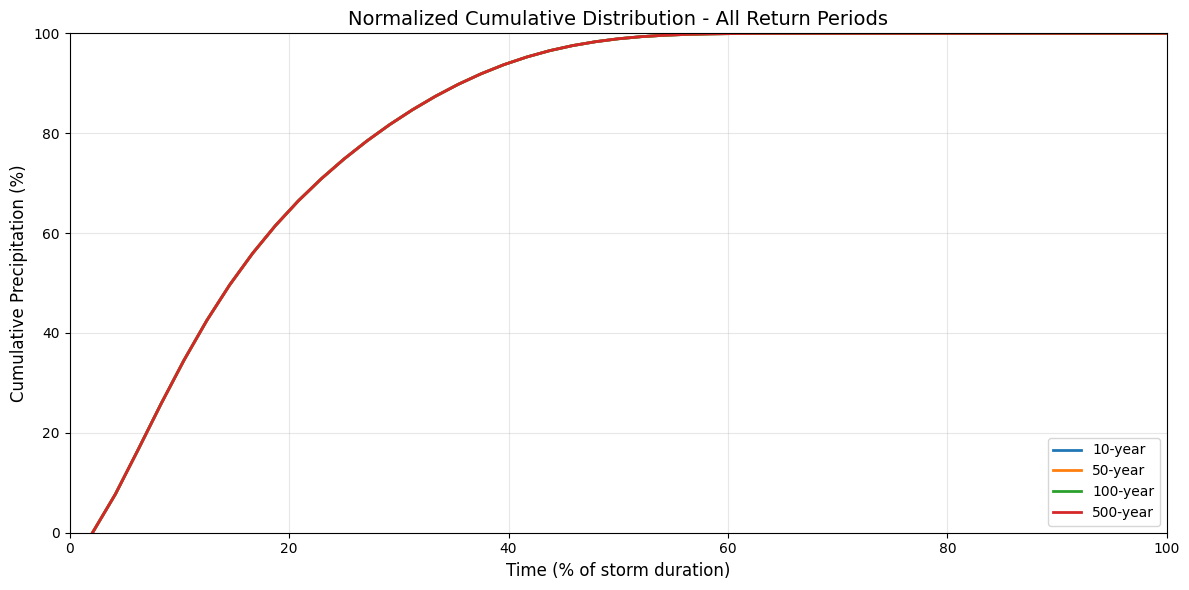

Note: All curves overlap because the temporal distribution is identical.
Only the total depth (scaling factor) differs between return periods.


In [7]:
fig, ax = plt.subplots(figsize=(12, 6))

for storm_name in ['10-year', '50-year', '100-year', '500-year']:
    hyeto = hyetographs[storm_name]
    
    # Normalize to percentage
    time_pct = hyeto['hour'] / 24 * 100
    cumulative_pct = hyeto['cumulative_depth'] / hyeto['cumulative_depth'].iloc[-1] * 100
    
    ax.plot(time_pct, cumulative_pct, '-', linewidth=2, label=storm_name)

ax.set_xlabel('Time (% of storm duration)', fontsize=12)
ax.set_ylabel('Cumulative Precipitation (%)', fontsize=12)
ax.set_title('Normalized Cumulative Distribution - All Return Periods', fontsize=14)
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()

print("Note: All curves overlap because the temporal distribution is identical.")
print("Only the total depth (scaling factor) differs between return periods.")

## 6. Working with Quartiles

Atlas 14 provides 5 quartile options that control the timing of peak intensity:
- **First Quartile**: Early peak (conservative for upstream flooding)
- **Second Quartile**: Early-to-median peak
- **Third Quartile**: Median-to-late peak
- **Fourth Quartile**: Late peak (conservative for downstream flooding)
- **All Cases**: Median temporal pattern (most common choice)

2026-01-08 13:29:44 - hms_commander.Atlas14Storm - INFO - Using cached temporal distribution: tx_3_24h


2026-01-08 13:29:44 - hms_commander.Atlas14Storm - INFO - Generated hyetograph: 49 intervals, 17.900 inches total


2026-01-08 13:29:44 - hms_commander.Atlas14Storm - INFO - Using cached temporal distribution: tx_3_24h


2026-01-08 13:29:44 - hms_commander.Atlas14Storm - INFO - Generated hyetograph: 49 intervals, 17.900 inches total


2026-01-08 13:29:44 - hms_commander.Atlas14Storm - INFO - Using cached temporal distribution: tx_3_24h


2026-01-08 13:29:44 - hms_commander.Atlas14Storm - INFO - Generated hyetograph: 49 intervals, 17.900 inches total


2026-01-08 13:29:44 - hms_commander.Atlas14Storm - INFO - Using cached temporal distribution: tx_3_24h


2026-01-08 13:29:44 - hms_commander.Atlas14Storm - INFO - Generated hyetograph: 49 intervals, 17.900 inches total


2026-01-08 13:29:44 - hms_commander.Atlas14Storm - INFO - Using cached temporal distribution: tx_3_24h


2026-01-08 13:29:44 - hms_commander.Atlas14Storm - INFO - Generated hyetograph: 49 intervals, 17.900 inches total


100-year Storm - Quartile Comparison
  First Quartile: peak=2.30 in @ 1.5h
 Second Quartile: peak=1.31 in @ 8.0h
  Third Quartile: peak=1.04 in @ 14.5h
 Fourth Quartile: peak=1.35 in @ 1.0h
       All Cases: peak=1.64 in @ 2.0h


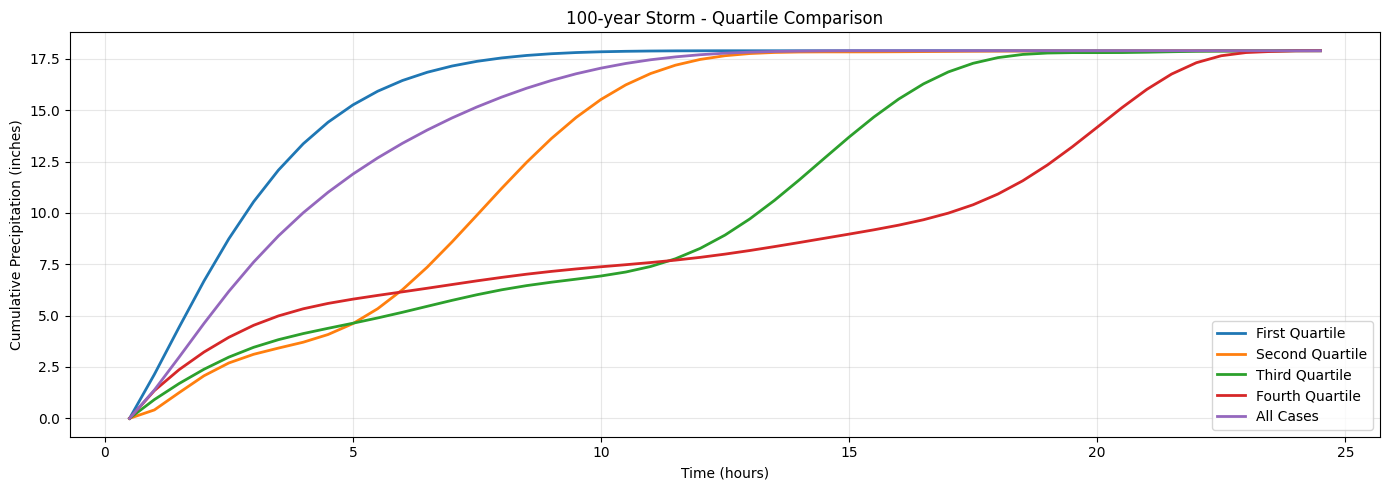

In [8]:
# Compare quartiles for 100-year storm
quartiles = ['First Quartile', 'Second Quartile', 'Third Quartile', 'Fourth Quartile', 'All Cases']
depth_100yr = 17.90

fig, ax = plt.subplots(figsize=(14, 5))

print("100-year Storm - Quartile Comparison")
print("=" * 60)

for quartile in quartiles:
    hyeto = Atlas14Storm.generate_hyetograph(
        total_depth_inches=depth_100yr,
        state=STATE,
        region=REGION,
        duration_hours=24,
        aep_percent=1.0,
        quartile=quartile
    )
    
    peak_idx = hyeto['incremental_depth'].idxmax()
    peak_time = hyeto['hour'].iloc[peak_idx]
    peak_depth = hyeto['incremental_depth'].max()
    
    print(f"{quartile:>16}: peak={peak_depth:.2f} in @ {peak_time:.1f}h")
    
    ax.plot(hyeto['hour'], hyeto['cumulative_depth'], '-', linewidth=2, label=quartile)

ax.set_xlabel('Time (hours)')
ax.set_ylabel('Cumulative Precipitation (inches)')
ax.set_title('100-year Storm - Quartile Comparison')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Export for HEC-RAS

Generate a hyetograph for use as a HEC-RAS boundary condition.

In [9]:
import pandas as pd

# Generate 100-year storm for RAS
hyeto_100yr = Atlas14Storm.generate_hyetograph(
    total_depth_inches=17.90,
    state="tx",
    region=3,
    duration_hours=24,
    aep_percent=1.0,
    quartile="All Cases"
)

# Create timestamp-indexed DataFrame for RAS
start_time = pd.Timestamp('2024-01-01 00:00:00')
hyeto_100yr['datetime'] = pd.date_range(
    start=start_time, 
    periods=len(hyeto_100yr), 
    freq='30min'
)

print("100-year Hyetograph for HEC-RAS")
print("=" * 50)
print(f"Total Depth: {hyeto_100yr['cumulative_depth'].iloc[-1]:.3f} inches")
print(f"Time Steps: {len(hyeto_100yr)}")
print(f"Interval: 30 minutes")
print(f"\nFirst 10 rows:")
print(hyeto_100yr[['datetime', 'hour', 'incremental_depth', 'cumulative_depth']].head(10).to_string(index=False))

# Export to CSV
output_file = Path('atlas14_100yr_24hr.csv')
hyeto_100yr[['datetime', 'incremental_depth']].to_csv(output_file, index=False)
print(f"\nExported to: {output_file}")

2026-01-08 13:29:44 - hms_commander.Atlas14Storm - INFO - Using cached temporal distribution: tx_3_24h


2026-01-08 13:29:44 - hms_commander.Atlas14Storm - INFO - Generated hyetograph: 49 intervals, 17.900 inches total


100-year Hyetograph for HEC-RAS
Total Depth: 17.900 inches
Time Steps: 49
Interval: 30 minutes

First 10 rows:
           datetime  hour  incremental_depth  cumulative_depth
2024-01-01 00:00:00   0.5            0.00000           0.00000
2024-01-01 00:30:00   1.0            1.38009           1.38009
2024-01-01 01:00:00   1.5            1.60384           2.98393
2024-01-01 01:30:00   2.0            1.63785           4.62178
2024-01-01 02:00:00   2.5            1.55909           6.18087
2024-01-01 02:30:00   3.0            1.42663           7.60750
2024-01-01 03:00:00   3.5            1.27448           8.88198
2024-01-01 03:30:00   4.0            1.12770          10.00968
2024-01-01 04:00:00   4.5            0.99703          11.00671
2024-01-01 04:30:00   5.0            0.88426          11.89097

Exported to: atlas14_100yr_24hr.csv


## Summary

### Key Capabilities

**Atlas14Storm generates design storm hyetographs WITHOUT HEC-HMS**:
- Uses official NOAA Atlas 14 temporal distributions
- Implements same algorithm as HEC-HMS "Specified Pattern"
- Guaranteed total depth conservation
- Supports all Atlas 14 quartiles

### Basic Usage

```python
from hms_commander import Atlas14Storm

hyeto = Atlas14Storm.generate_hyetograph(
    total_depth_inches=17.9,  # From Atlas 14 DDF table
    state="tx",
    region=3,
    duration_hours=24,
    aep_percent=1.0,          # 100-year storm
    quartile="All Cases"
)
```

### Available Durations

NOAA provides temporal distributions for: **6h, 12h, 24h, 96h**

**Note**: 48-hour is NOT available from NOAA. Use `FrequencyStorm` for 48-hour storms.

### Next Steps

- **Notebook 11**: FrequencyStorm for variable duration storms
- **Notebook 13**: Multi-duration validation with equivalence proofs